# VanZyl-1 Quick Start

This guide shows everything you'll need to get started accessing, processing, and analyzing data from Hydrosat's VanZyl-1 satellite.

## 1. Import dependencies.

In [1]:
import json
import requests
import pystac
from pystac_client import Client
import os
import base64
import matplotlib.pyplot as plt

## 2. Connect to the STAC API with your account credentials.

#### Note: This step is optional if accessing imagery from Hydrosat's Open Data program.

Before running this next cell, you'll need to create a `creds.json` file in the same directory as this notebook.

The format of the file should be:

```
{
"username":"<your_username>",
"password":"<your_password>"
}
```

Leave the quotation marks as is.

In [2]:
with open('creds.json') as f:
    creds = json.loads(f.read())

This next cell will endecode the `username:password` combination and use it to authorize access to the STAC API given by the `cat_url` endpoint. You don't need to make any changes here.

In [3]:
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

Now you can explore the VZ-1 STAC catalog!

## 3. Search the catalog for the data you're interested in.

The catalog contains VZ-1 imagery from around the globe. We can use the ```catalog.search()``` function to search for data that intersects with a specific geometry and/or range of dates.

We'll start by defining the list of collections that contain VZ-1 data.

In [4]:
collections = ["pydms_sharpened_landsat"] # SUB THIS FOR VZ COLLECTIONS WHEN AVAILABLE

Next, we'll define a point geometry in California's Central Valley.

In [5]:
geom = {'type': 'Point', 'coordinates': [-120.211,36.535]} # Point for Hanford, CA, USA

We'll also specify the start and end dates (and times) for the search.

In [6]:
start_date = "2021-08-17"
start_time = "T00:00:00Z"

end_date = "2021-10-30"
end_time = "T00:00:00Z"

Each of these variables is used as an input to ```catalog.search()```. Be patient! You may need to wait several seconds for the response to your query.

In [7]:
search = catalog.search(
    collections = collections,
    intersects = geom,
    datetime = [start_date+start_time, end_date+end_time],
    max_items = 10
)

items = search.get_all_items()

print("Found " + str(len(list(items))) + " items.")

/opt/conda/lib/python3.11/site-packages/pystac_client/item_search.py:850: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


Found 8 items.


## 4. Explore the items returned from your search.

Let's take a closer look at the items meeting the criteria we submitted to ```catalog.search()```.

First, we'll print the unique ```id``` for each item. The ```id``` includes the date and time the image was captured, as well as the processing level. Hydrosat's VZ-1 data products are provided at three levels:

- Level 1A: Geolocated radiance (pixel resolution equivalent to GSD)
- Level 1B: Geolocated radiance (LWIR and VNIR data aligned and resampled to 30 m)
- Level 2: Surface reflectance and land surface temperature (30 m)

In [8]:
import pprint
pprint.pp(list(items))

[<Item id=sharpened_10SGF_hires_lst_mosaic_screened_LC08_20211024_with_S2_10SGF_median_composite_20211026_screened>,
 <Item id=sharpened_10SGF_hires_lst_mosaic_screened_LC08_20211017_with_S2_10SGF_median_composite_20211016_screened>,
 <Item id=sharpened_10SGF_hires_lst_mosaic_screened_LC08_20211008_with_S2_10SGF_median_composite_20211008_screened>,
 <Item id=sharpened_10SGF_hires_lst_mosaic_screened_LC08_20211001_with_S2_10SGF_median_composite_20211001_screened>,
 <Item id=sharpened_10SGF_hires_lst_mosaic_screened_LC08_20210915_with_S2_10SGF_median_composite_20210916_screened>,
 <Item id=sharpened_10SGF_hires_lst_mosaic_screened_LC08_20210906_with_S2_10SGF_median_composite_20210906_screened>,
 <Item id=sharpened_10SGF_hires_lst_mosaic_screened_LC08_20210830_with_S2_10SGF_median_composite_20210901_screened>,
 <Item id=sharpened_10SGF_hires_lst_mosaic_screened_LC08_20210821_with_S2_10SGF_median_composite_20210822_screened>]


### What's in an item anyway?

Each item represents a single VZ-1 scene as a GeoJSON feature. It contains a series of ```assets``` that link to the imagery files, ```properties``` representing different metadata attributes, a ```bbox``` containing its spatial footprint, and more. Let's look through the first item.

In [9]:
items[0]

<Item id=sharpened_10SGF_hires_lst_mosaic_screened_LC08_20211024_with_S2_10SGF_median_composite_20211026_screened>

Each item contains the following ```assets```:

In [10]:
for key, asset in items[0].assets.items():
    print(f"{key}: {asset.title}")

lst: Sharpened Land Surface Temperature
pydms_residual: Sharpened Land Surface Temperature Residual Error
valid_data_mask: Sharpened Land Surface Temperature Boolean Mask
combined_qa: Sharpened Combined QA Band
preview: Preview image
thumbnail: Thumbnail image


In the next section, we'll access those assets directly.

But first, we'll use ```geopandas``` to load all of the items into a dataframe that can be sorted, filtered, and explored. Each column represents a different feature of the imagery or its acquisition.

In [11]:
import geopandas as gpd

df = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
df

,geometry,product,mgrs_tile,processing:software,processing:lineage,processing:level,hydrosat:stage,hydrosat:fusion_inputs,datetime,processing:prep-sharpen-fuse-version,...,processing:test_mode,processing:time_of_day_range,processing:url,hydrosat:data_coverage,created,updated,tile,processing:qa_screen_bool,processing:gapfill,processing:global_only
0,"POLYGON ((-120.75207 37.02528, -119.51941 36.9...",Landsat,10SGF,"{'geo-pipeline': 'default', 'pydms': '1.0.0'}",,L3,sharpen_output,"[t0_pair, hires]",2021-10-24T18:40:31.954596Z,26.1,...,False,"[0, 23]",,0.01,2023-01-12T21:30:00.119Z,2023-05-09T01:05:49.962Z,NaN,NaN,NaN,NaN
1,"POLYGON ((-120.75207 37.02528, -119.51941 36.9...",Landsat,10SGF,"{'geo-pipeline': 'default', 'pydms': '1.0.0'}",,L3,sharpen_output,"[t0_pair, hires]",2021-10-17T18:34:20.745578Z,26.1,...,False,"[0, 23]",,49.47,2023-01-12T21:30:00.205Z,2023-05-09T01:16:44.371Z,NaN,NaN,NaN,NaN
2,"POLYGON ((-120.75207 37.02528, -119.51941 36.9...",Landsat,10SGF,"{'geo-pipeline': 'default', 'pydms': '1.0.0'}",,L3,sharpen_output,"[t0_pair, hires]",2021-10-08T18:40:29.892806Z,26.1,...,False,"[0, 23]",,75.18,2023-01-12T21:29:59.639Z,2023-05-09T04:05:25.192Z,NaN,NaN,NaN,NaN
3,"POLYGON ((-120.78053 37.02528, -120.78053 36.0...",Landsat,NaN,"{'geo-pipeline': 'default', 'pydms': '1.0.0'}",,L3,sharpen_output,"[t0_pair, hires]",2021-10-01T18:34:04.851373Z,20.0,...,False,"[0, 23]",,NaN,2023-01-12T21:29:56.792Z,2023-01-18T14:02:52.531Z,10SGF,"{'landsat': True, 'S2': True, 'ECO': True, 'MC...",True,False
4,"POLYGON ((-120.75207 37.02528, -119.51941 36.9...",Landsat,10SGF,"{'geo-pipeline': 'default', 'pydms': '1.0.0'}",,L3,sharpen_output,"[t0_pair, hires]",2021-09-15T18:34:12.169587Z,26.1,...,False,"[0, 23]",,67.45,2023-01-12T21:29:55.077Z,2023-05-09T03:22:10.312Z,NaN,NaN,NaN,NaN
5,"POLYGON ((-120.75207 37.02528, -119.51941 36.9...",Landsat,10SGF,"{'geo-pipeline': 'default', 'pydms': '1.0.0'}",,L3,sharpen_output,"[t0_pair, hires]",2021-09-06T18:40:21.164950Z,26.1,...,False,"[0, 23]",,79.68,2023-01-12T21:29:54.771Z,2023-05-09T02:12:30.144Z,NaN,NaN,NaN,NaN
6,"POLYGON ((-120.78053 37.02528, -120.78053 36.0...",Landsat,NaN,"{'geo-pipeline': 'default', 'pydms': '1.0.0'}",,L3,sharpen_output,"[t0_pair, hires]",2021-08-30T18:33:56.253740Z,20.0,...,False,"[0, 23]",,NaN,2023-01-12T21:29:54.782Z,2023-01-18T14:02:52.521Z,10SGF,"{'landsat': True, 'S2': True, 'ECO': True, 'MC...",True,False
7,"POLYGON ((-120.75207 37.02528, -119.51941 36.9...",Landsat,10SGF,"{'geo-pipeline': 'default', 'pydms': '1.0.0'}",,L3,sharpen_output,"[t0_pair, hires]",2021-08-21T18:40:16.415650Z,26.1,...,False,"[0, 23]",,80.82,2023-01-12T21:29:55.049Z,2023-05-09T04:07:11.399Z,NaN,NaN,NaN,NaN


We can  use ```df.explore()``` to plot each item's spatial footprint on an interactive map. Hover over each polygon to see that item's date and time.

In [12]:
df[["geometry","datetime"]].explore(style_kwds={"fillOpacity": 0.1})

The structure of ```df``` allows us to plot any of the items' ```properties``` over time. Here, we'll inspect the```data_coverage``` parameter.

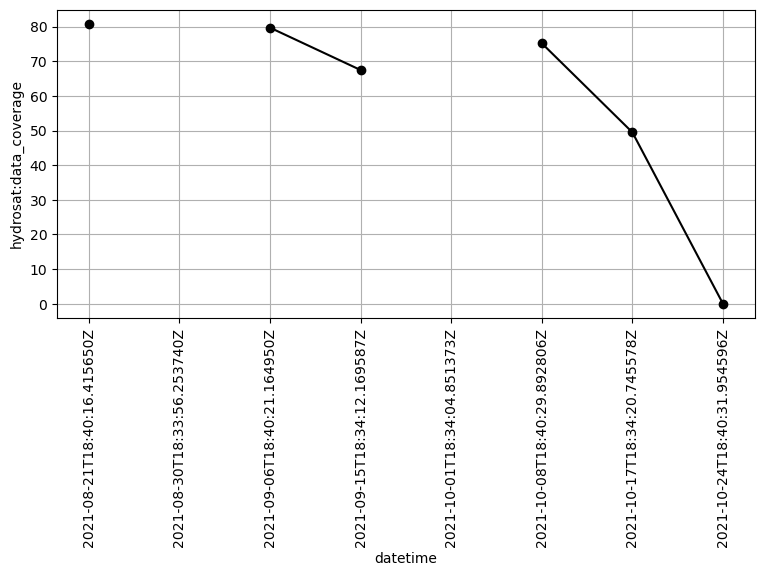

In [13]:
# Sort the dataframe by datetime (oldest to newest) and plot data coverage as time series
df.set_index("datetime").sort_index()["hydrosat:data_coverage"].plot(figsize=(9,4),
                                                ylabel="hydrosat:data_coverage",
                                                color='black',
                                                style='.-', 
                                                ms=12, # marker size
                                                grid=True,
                                                rot=90);

Now let's evaluate the imagery itself.

## 5. Analyze and visualize the data.

We can use ```rioxarray``` to open the asset that contains the land surface temperature imagery from the first item.

In [14]:
import rioxarray

lst_href = items[0].assets["lst"].href # URL to the location where the imagery is stored
lst = rioxarray.open_rasterio(lst_href).squeeze()
lst

<xarray.DataArray (y: 5490, x: 5490)>
[30140100 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05 8.098e+05
  * y            (y) float64 4.1e+06 4.1e+06 4.1e+06 ... 3.99e+06 3.99e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0

Let's plot the full LST image.

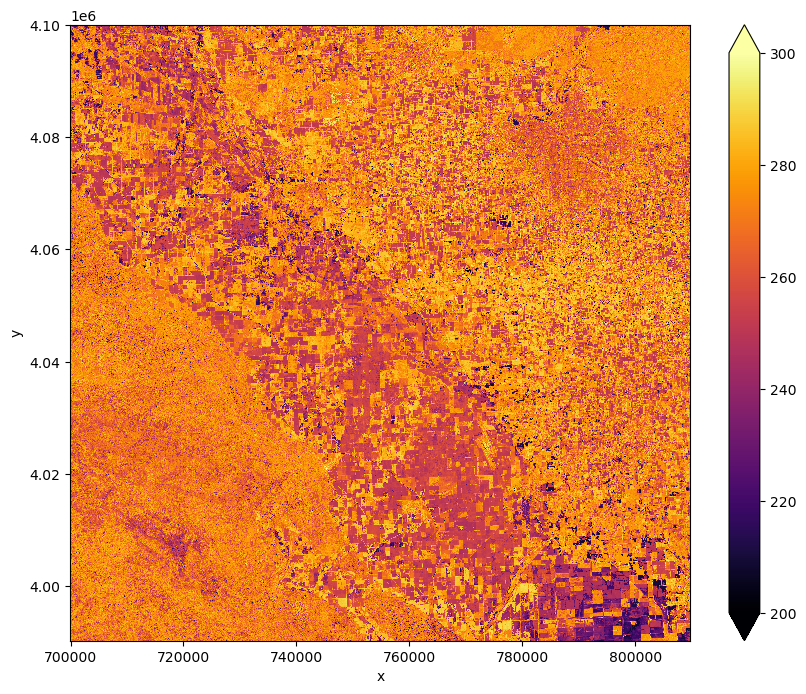

In [15]:
plt.figure(figsize=(10,8))
lst.plot.imshow(cmap='inferno', vmin=200, vmax=300);
plt.title('');

The ```x``` and ```y``` axes represent geographic coordinates (UTM).

Let's look at the distribution of LST values across the entire image.

Text(0.5, 1.0, '')

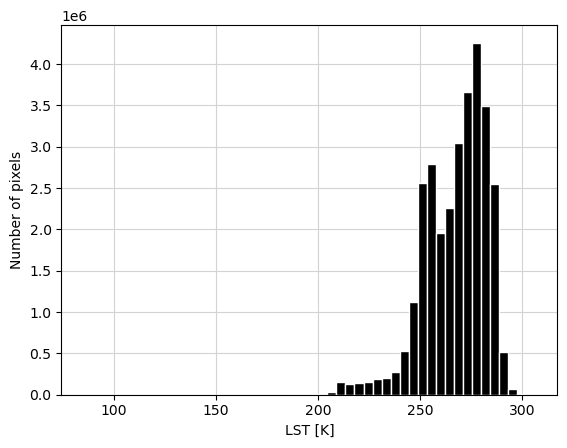

In [16]:
lst.plot.hist(bins=50, facecolor='black', edgecolor='white', zorder=2);
plt.xlabel('LST [K]');
plt.ylabel('Number of pixels');
plt.grid(which='major', axis='both', color='lightgray')
plt.title('')

We can use ```rio.clip_box()``` to plot a smaller subset of the image. For the purposes of this example, the exact location of this subset within the larger image is selected randomly.

Text(0.5, 1.0, '')

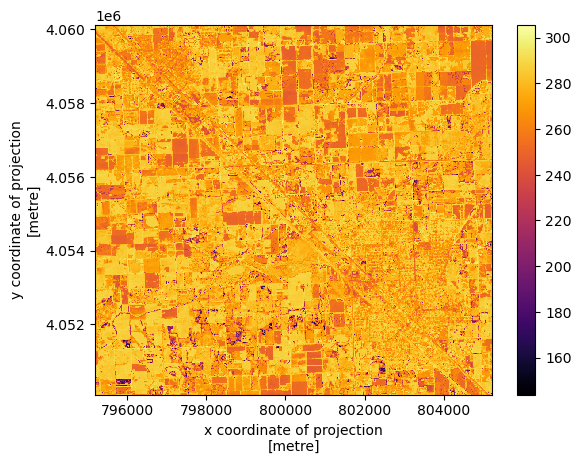

In [18]:
import random

# For the bottom and left edges of the clipped image, randomly select an x and a y coordinate
minx, miny = random.choice(lst.x.values), random.choice(lst.y.values)

# For the top and right edges, add a very small number to each coordinate
maxx, maxy = minx+1e4, miny+1e4

lst.rio.clip_box(minx=minx, 
                 miny=miny,
                 maxx=maxx,
                 maxy=maxy).plot.imshow(cmap='inferno')

plt.title('')